

<font size = "5"> **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Multislice Algorithm

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM//main/Diffraction/CCH2_D02-Multi_Slice.ipynb)

part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2022

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes


## Introduction
In this notebook, we will make a dynamic simulation of the scattering process.

The core of this algorithm is used in many different libraries.

I follow in my description mostly the book of Kirkland, from where we also use the scattering parameters. The code has been completely rewritten so that the mechnaism of the algorithm can be understood on a basic level. 

All commercial and open-source codes use the same base algorithm but are highly tuned for usability, variabilty, features and speed. This was not the goal here.

Here are a few of the more common open-source programs
- [abTEM](https://github.com/jacobjma/abTEM)
- [clTEM](https://github.com/JJPPeters/clTEM)
- [MuSTEM](https://github.com/ningustc/MuSTEM)
- [Dr. Probe](https://er-c.org/barthel/drprobe/)


## Load relevant python packages
### Check Installed Packages

In [4]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2022.3.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

done


### Import numerical and plotting python packages
Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries, we need 3D plotting library and some scipy libraries

and a library from pyTEMlib:
* kinematic scattering library.

In [20]:
%pylab --no-import-all notebook

# additional package 
from mpl_toolkits.mplot3d import Axes3D 
import itertools
import scipy.constants
import scipy.special 

# Import libraries from pyTEMlib
import pyTEMlib
import pyTEMlib.kinematic_scattering as ks         # Kinematic sCattering Library
                             # Atomic form factors from Kirkland's book

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

__notebook__ = 'CH2_D02-Multislice'
__notebook_version__ = '2022_02_25'

Populating the interactive namespace from numpy and matplotlib
pyTEM version:  0.2022.2.5


## Overview of Multislice Algorithm

The multislice solution is formally equivalent to a solution of the [``Howie-Whelan equation``](https://doi-org.proxy.lib.utk.edu/10.1098/rspa.1961.0157) (which is the differential form of the Bloch wave solution), if the slice thickness $\Delta$z is small enough. 

The idea is to slice the sample into thin slices that can be handled well in electron diffraction.

And then we step through these slices one by one and keep track of the incoming and exiting wave.

We seperate (serialize) the problem to conquer it iteratively.

The algorithm can be divided in several steps.

1. So first we need the projected atomic potentials for each element.
2. Then we need to build the slices. The slices are one layer of atoms which are all at the top. And then we have vacuum for the rest.
3. The transmission function will deal with the distorition of the wave by the atom potentials.
4. The Fresnel propagator takes care of the vacuum between the atomic layers.
5. We need to define the incident wave.
6. We let this wave travel through the different layers, iteratively.

Step 3 is done in real space and step 4 in Fourier Space and so a lot of Fourier transfom is going on. This lends itself  speed-up through parallel fast Fourier transform algorithms, which you can see at the increasing codes with gpu usage.

## Step1: Projected Potential 

Providing the potentials and placing the atoms is a surprisingly computer intensive task for initialization of the simulation. This notebook gives up flexibility for speed in placing the atoms (no sub-pixel movement).

### Projected Potential from Parametrization of Atomic Form Factor
Following Kirkland (2$^nd$ edition Appendix C page 252),
the atom potential is with $r^2 = x^2+z^2+z^2$ and $V(x,y,z) =V(\vec{r})$ 
$$
\begin{eqnarray}
v(x, y, z) &=&  2 \pi a_0 e_0 \int f_e(q) \exp \left( -2 \pi i \vec{q} \vec{r}  \right)  d^3r \\
&=& 2 \pi^2 a_0 e_0 \sum_i \frac{a_i}{r} \exp \left( -2 \pi r  \sqrt{b_i} \right) + 2\pi^{5/2} a_0 e_0 \sum_i c_i d_i^{-3/2} \exp \left(\frac{-\pi^2 r^2}{d_i} \right)
\end{eqnarray}
$$
with $r^2 = x^2+z^2+z^2$

The ``projected potential`` is then:
$$
\begin{eqnarray}
v_z(x,y) &=& \int_{-\inf}^{\inf} V(x,y,z) dz \\
&=& 4 \pi^2 a_0 e_0 \sum_i a_i K_0 \left( 2 \pi r \sqrt{b_i} \right)
+ 2 \pi^2 a_0 e_0 \sum_i \frac{c_i}{d_i} \exp \left( \frac{-\pi^2 r^2}{d_i} \right)\\
&=& 2 \pi^2 a_0 e_0 \left[2 \sum_i a_i K_0 \left( 2 \pi r \sqrt{b_i} \right) 
+\sum_i \frac{c_i}{d_i} \exp \left( \frac{-\pi^2 r^2}{d_i} \right) \right]
\end{eqnarray}
$$
with $ r^2 = x^2 + y^2$, we need to calculate the 1D potential only, dueto the radial symmetry of atoms.

The ``spherical Bessel function`` $\bf K_0$ is providedby the ``scipy`` special package.

We will use the last of the equations in our calculation.

The setting up of the potential can take quite some computer power, so there are a few constricts in this notebook on where to put the atoms, these constricts can easily be overcome

In [21]:
def potential_1D(element, r):
    """calculates the projected potential of an atom of element 
    
    The projected potential will be in units of V nm^2,
    however, internally we will use Angstrom instead of nm!
    """
    
    # get lementary constants
    a0 = scipy.constants.value('Bohr radius') * 1e10  #in Angstrom
    Ry_div_e = scipy.constants.value('Rydberg constant times hc in eV') # in V
    e0 = 2* Ry_div_e * scipy.constants.value('Bohr radius') * 1e10

    pre_factor = 2.0 * np.pi**2 * a0 * e0

    param = ks.electronFF[element]  # parametrized form factors
    fL = r*0  # Lorentzian term
    fG = r*0  # Gaussian term
    for i in range(3):
        fL += param['fa'][i] * scipy.special.k0(2 * np.pi * r * np.sqrt(param['fb'][i]))
        fG += param['fc'][i] / param['fd'][i] * np.exp(-np.pi**2 * r**2 / param['fd'][i])
    fL[0,0] = fL[0,1]
    
    return pre_factor * (2 * fL + fG) /100 # V Angstrom^2


To retrieve the atomic projected potential, the function above uses a rather unconventional unit for the elementary charge $e$.

Starting from the relationship for the Rydberg energy: 
$$Ry = 0.5 e^2/ a_0 $$

and using the value for $Ry$ as 13.6 eV so that $Ry/e = 13.6$ V;  we get:

$$e_0 = 2* a_0 Ry/e$$

>
>The elementary charge $e_0$ is then 1.44 V nm 
>

for $a_0 = 0.0529$ nm

In [22]:
Ry  = scipy.constants.value('Rydberg constant times hc in eV') # in V
print(f'Ry = {Ry:.4f} eV and Ry/e = {Ry:.4f} V')
e = 2*  Ry *scipy.constants.value('Bohr radius') * 1e9  # conversion to nm
print(f'elemntary charge e = {e:.4f} V nm')

Ry = 13.6057 eV and Ry/e = 13.6057 V
elemntary charge e = 1.4400 V nm


### Plot quarter of projected atom potential

We now use this function to plot a projected atom potential up in a 1nm by 1nm image. 

In [23]:
def potential_1D(element, r):
    """calculates the projected potential of an atom of element 
    
    The projected potential will be in units of V nm^2,
    however, internally we will use Angstrom instead of nm!
    """
    
    # get lementary constants
    a0 = scipy.constants.value('Bohr radius') * 1e10  #in Angstrom
    Ry_div_e  = scipy.constants.value('Rydberg constant times hc in eV') # in V
    e0 = 2*  Ry_div_e * scipy.constants.value('Bohr radius') * 1e10
    
    pre_factor = 2 * np.pi ** 2 * a0 * e0

    param = ks.electronFF[element]  # parametrized form factors
    fL = r*0  # Lorentzian term
    fG = r*0  # Gaussian term
    for i in range(3):
        fL += param['fa'][i] * scipy.special.k0(2 * np.pi * r * np.sqrt(param['fb'][i]))
        fG += param['fc'][i] / param['fd'][i] * np.exp(-np.pi**2 * r**2 / param['fd'][i])
    fL[0,0] = fL[0,1]
    
    return pre_factor * (2 * fL + fG)  # V Angstrom^2


<IPython.core.display.Javascript object>


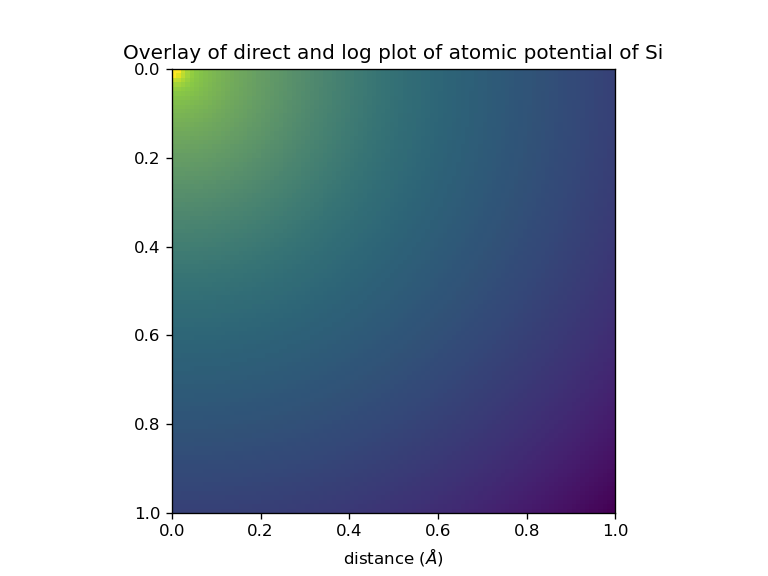

Text(0.5, 0, 'distance ($\\AA$)')

In [5]:
# ------ Input ----- #
element_name = 'Si'
# ------------------ #

pixel_size = 0.01

a_nx = a_ny = int(1/pixel_size)
x,y = np.mgrid[0:a_nx, 0:a_ny] * pixel_size

r = x**2+y**2 
#r[r<pixel_size] = pixel_size/4
atom_potential = potential_1D('Si', r)

plt.figure()
plt.title(f'Overlay of direct and log plot of atomic potential of {element_name}')
plt.imshow(np.log(atom_potential), extent=[0,a_nx*pixel_size,a_ny*pixel_size,0])
plt.imshow(atom_potential, extent=[0,a_nx*pixel_size,a_ny*pixel_size,0], alpha =0.4)

plt.xlabel('distance ($\AA$)')

### Plot full projected atom potential
Now, that we have a quarter of the atom potential, we make the round one, by flipping our dataset around.

<IPython.core.display.Javascript object>


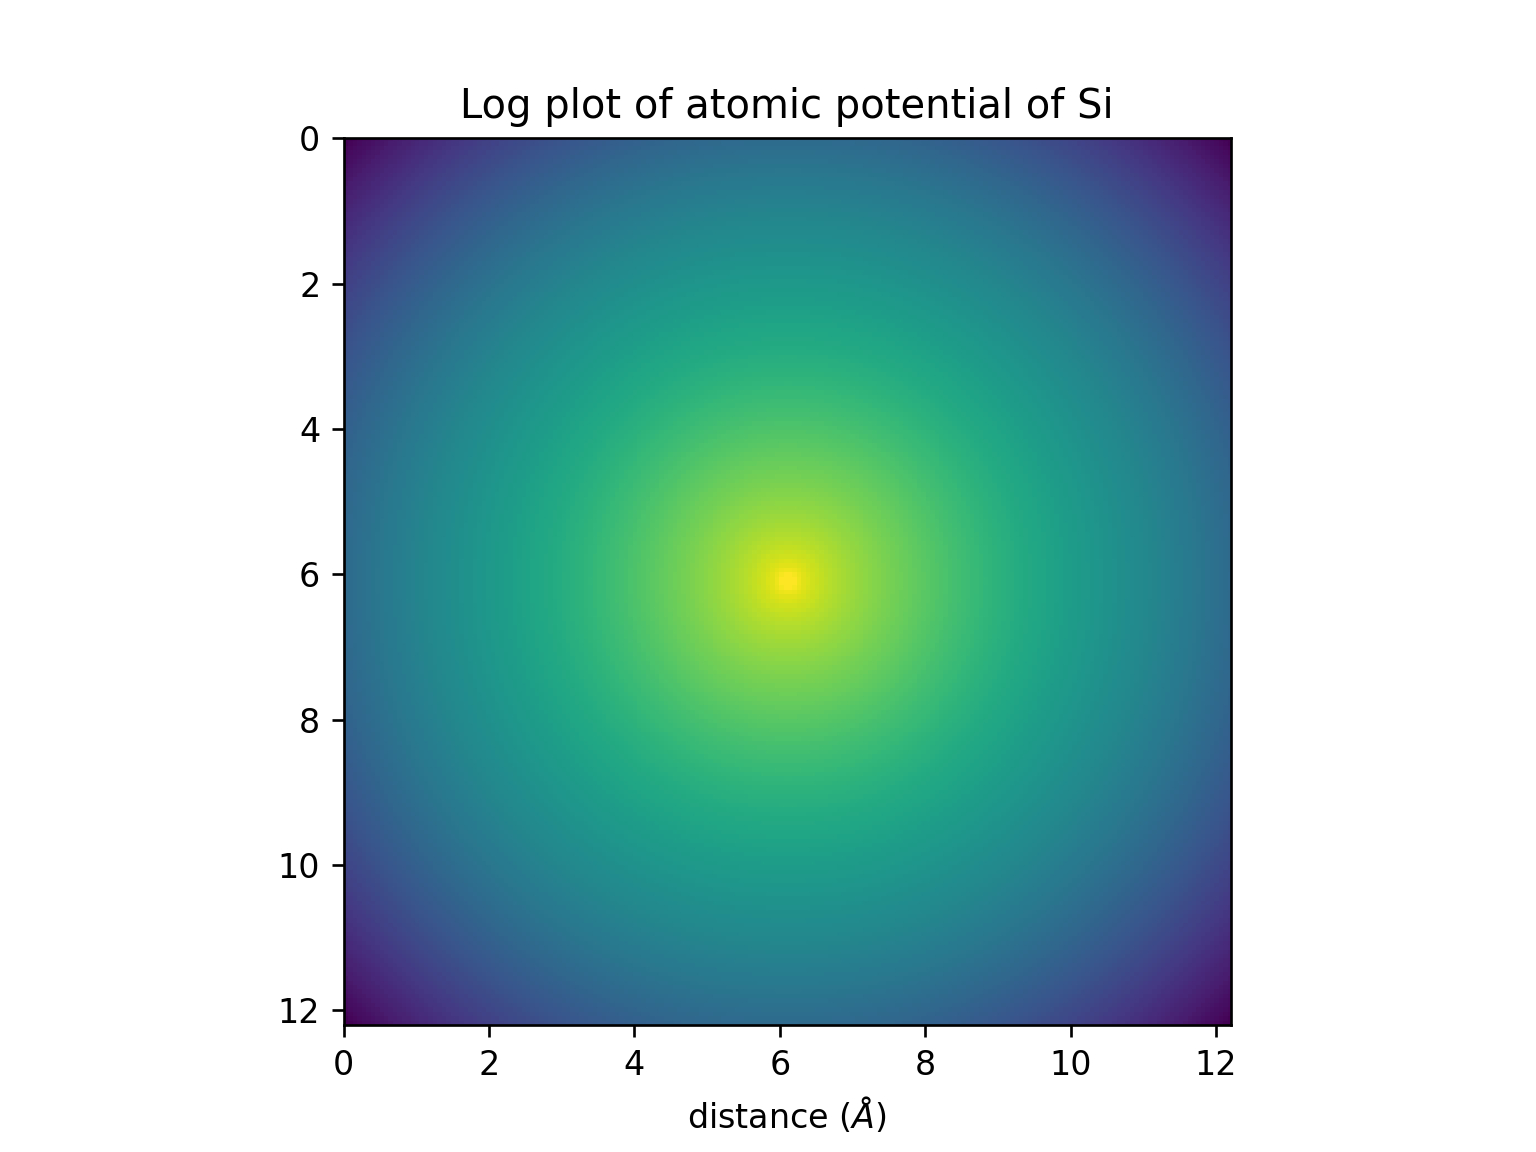

In [24]:
atom_potential_round = np.zeros([2*a_nx, 2*a_ny])
atom_potential_round[a_nx:,a_ny:] = atom_potential
atom_potential_round[a_nx:,:a_ny] = np.flip(atom_potential, axis=1)
atom_potential_round[:a_nx,a_ny:] = np.flip(atom_potential, axis=0)
atom_potential_round[:a_nx,:a_ny] = np.flip(np.flip(atom_potential, axis=0), axis=1)
plt.figure()
plt.title(f'Log plot of atomic potential of {element_name}')

plt.imshow(np.log(atom_potential_round), extent=[0,2*a_nx*pixel_size,2*a_ny*pixel_size,0])
plt.xlabel('distance ($\AA$)');

### Embedd atoms in projected crystals

We place the atom in the corner of a matrix with the same size as the image to be simulated.

With the numpy roll function we now can move this atom wherever we want, but only with pixel precision.


<IPython.core.display.Javascript object>


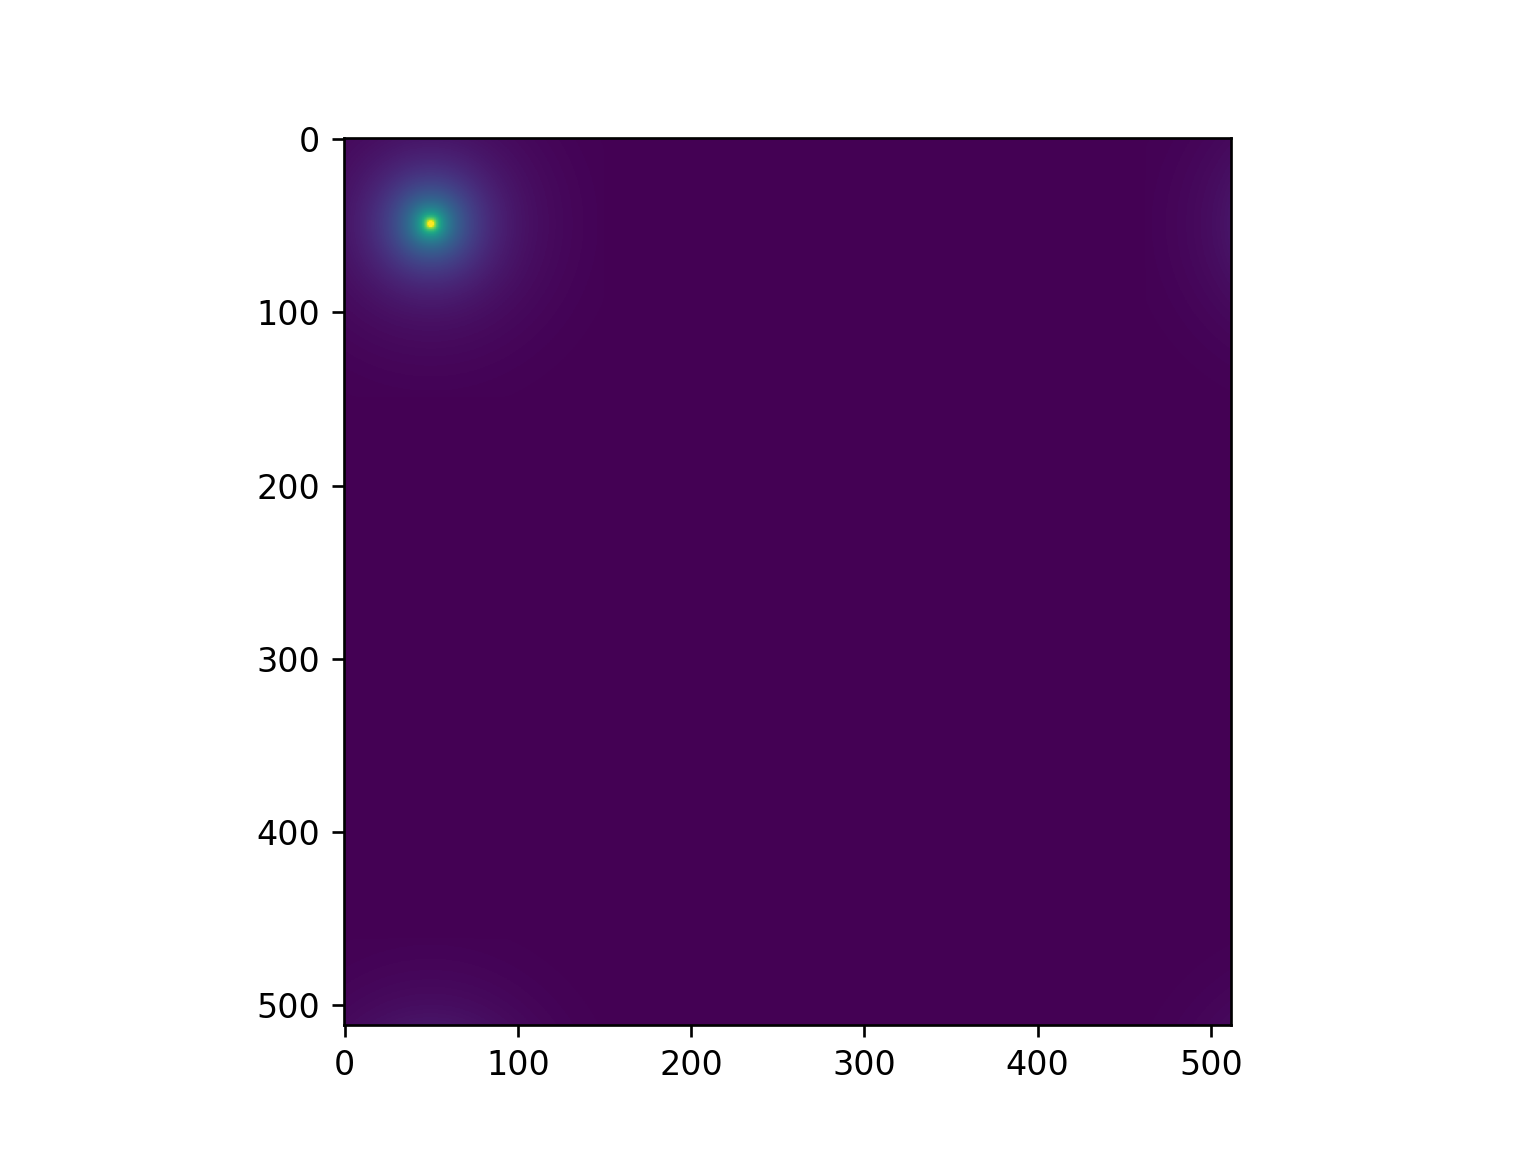

In [25]:
size_in_pixel = nx = ny =  512

atom_potential_corner = np.zeros([nx,ny])

atom_potential_corner[0:a_nx, 0:a_ny] = atom_potential
atom_potential_corner[nx-a_nx:,0:a_ny] = np.flip(atom_potential, axis=0)
atom_potential_corner[0:a_nx,ny-a_ny:] = np.flip(atom_potential, axis=1)
atom_potential_corner[nx-a_nx:,ny-a_ny:] = np.flip(np.flip(atom_potential, axis=0), axis=1)


plt.figure()
plt.imshow(np.roll(atom_potential_corner, shift = [50,50], axis = [0,1]))


### Projected Potential of Supercell

With a projected base and unit cell we know where to place the projected potentials (in pixels). We use the translational symmetery of a crystal here to multiply the portentails in the projected unitcell to make a supercell.

A more sophisticated program will allow you to place atoms potentials precisly and conveniently for each slice

<IPython.core.display.Javascript object>


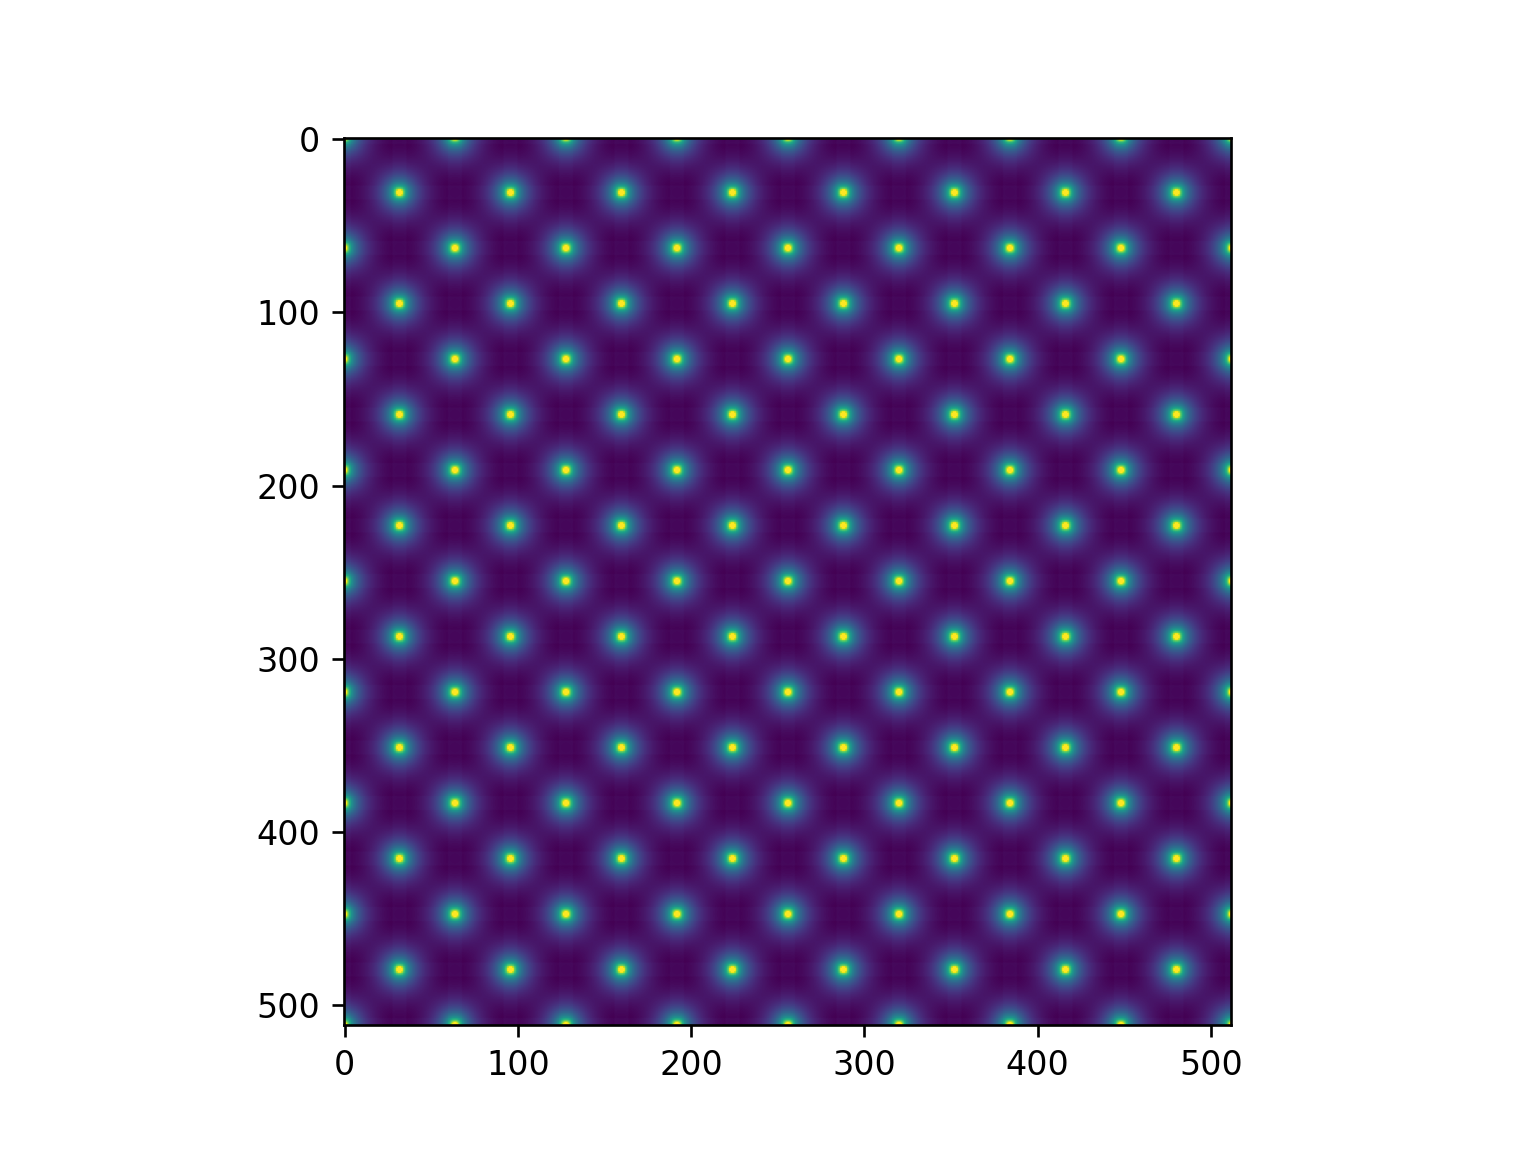

In [26]:
number_of_unit_cells_x = 8
unit_cell_base = np.array([[0.0, 0.0] , [0.5,0.5] ])

potential_unit_cell = np.zeros([nx,ny])
atom_potential_corner = np.zeros([nx,ny])

potential = np.zeros([nx,ny])

atom_potential_corner[0:a_nx, 0:a_ny] = atom_potential
atom_potential_corner[nx-a_nx:,0:a_ny] = np.flip(atom_potential, axis=0)
atom_potential_corner[0:a_nx,ny-a_ny:] = np.flip(atom_potential, axis=1)
atom_potential_corner[nx-a_nx:,ny-a_ny:] = np.flip(np.flip(atom_potential, axis=0), axis=1)

unit_cell_base = np.array(unit_cell_base*nx/8, dtype= int)

for pos in unit_cell_base:
    potential_unit_cell = potential_unit_cell + np.roll(atom_potential_corner, shift = pos, axis = [0,1])
    
for i in range(number_of_unit_cells_x):
    for j in range(number_of_unit_cells_x):
        potential = potential + np.roll(potential_unit_cell, shift = [i*64,j*64], axis = [0,1])
plt.figure()
plt.imshow((potential) )

### All together in a function

All the code from above we now collect in a single function

<IPython.core.display.Javascript object>


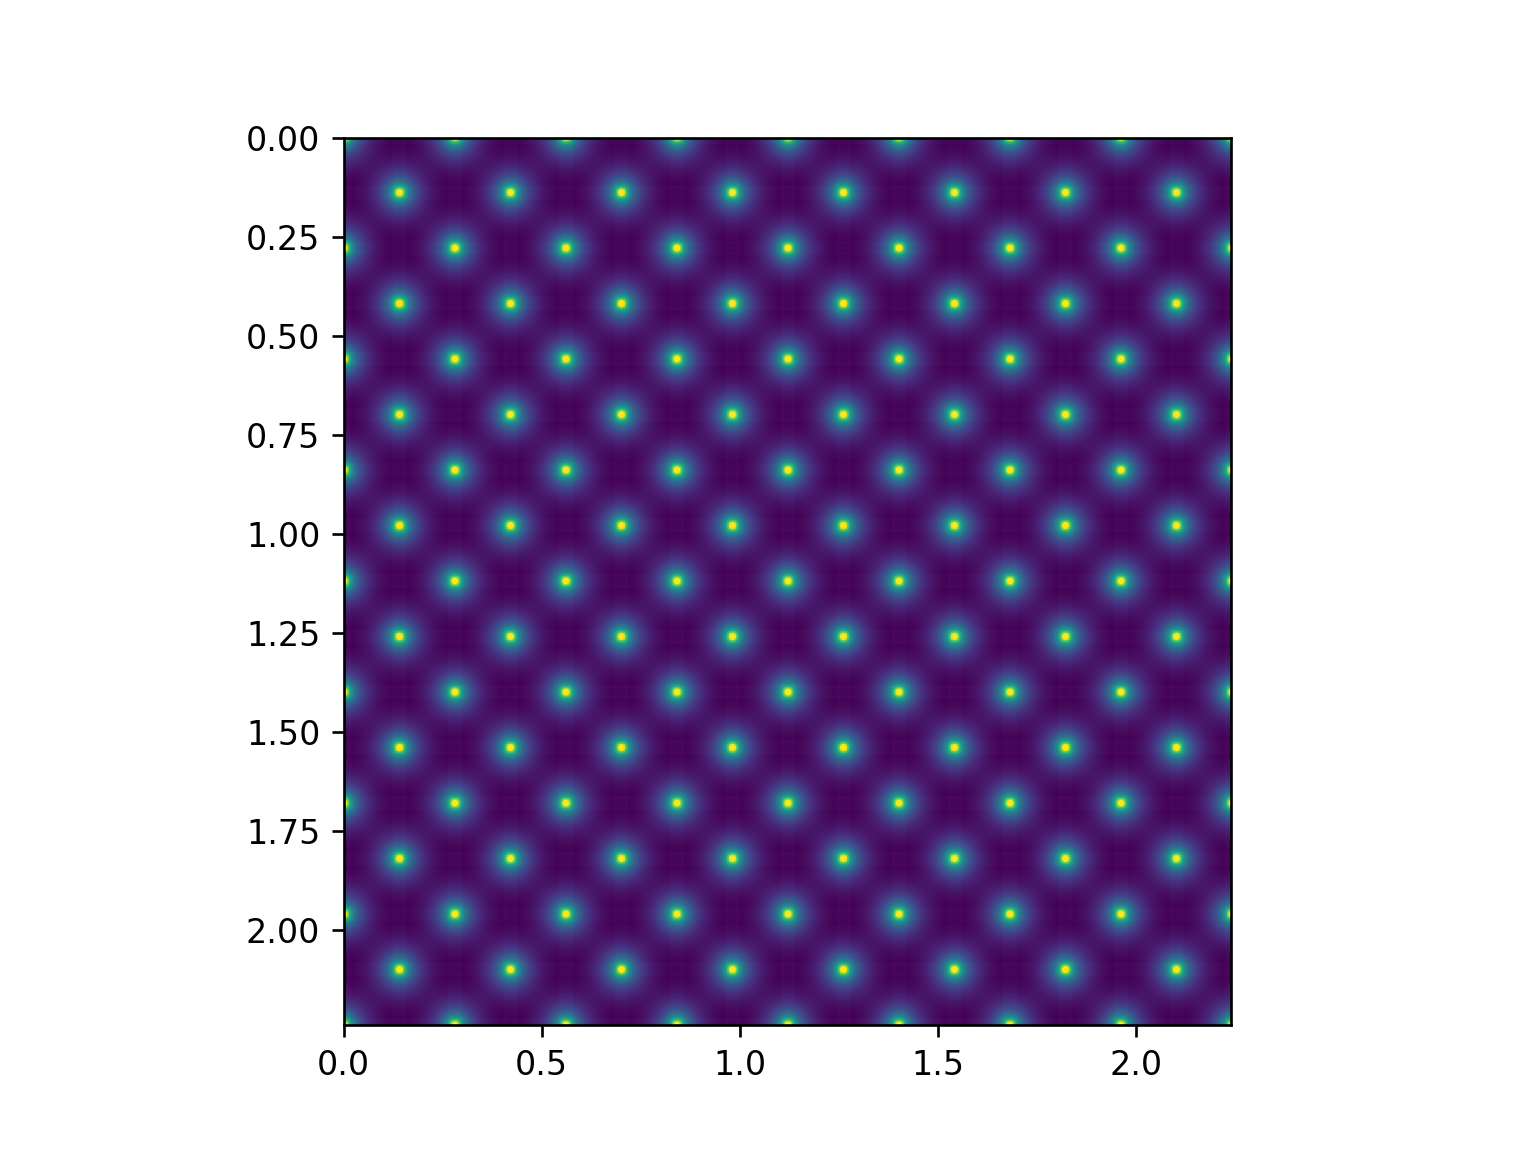

In [27]:
def potential_2D(element, nx, ny, n_cell_x, n_cell_y, lattice_parameter, base):
    n_cell_x = int(2**np.log2(n_cell_x))
    n_cell_y = int(2**np.log2(n_cell_y))
    
    pixel_size = lattice_parameter/(nx/n_cell_x)
    
    a_nx = a_ny = int(1/pixel_size)
    x,y = np.mgrid[0:a_nx, 0:a_ny] * pixel_size
    a = int(nx/n_cell_x)
    r = x**2+y**2 
    atom_potential = potential_1D(element, r)

    potential = np.zeros([nx,ny])

    unit_cell_base = np.array(base)*a
    unit_cell_base = np.array(unit_cell_base, dtype= int)
    

    for pos in unit_cell_base:
        potential = potential + np.roll(atom_potential_corner, shift=np.array(pos), axis = [0,1])
    
    for column in range(int(np.log2(n_cell_x))):
        potential = potential + np.roll(potential, shift = 2**column * a, axis = 1)
    for row in range(int(np.log2(n_cell_y))):
        potential = potential + np.roll(potential, shift = 2**row * a, axis = 0)
    
    return potential

size_in_pixel = 512
number_layers = 2
n_cell_x = 8
a = 0.28

potential = potential_2D('Si', size_in_pixel, size_in_pixel, n_cell_x, n_cell_x, a, [[0,0], [0.5,0.5]])
pixel_size = a/(nx/n_cell_x)
plt.figure()
plt.imshow((potential), extent=[0,nx*pixel_size, ny*pixel_size, 0 ])

## Step 2: Slice Crystal.

The above crystal is an artificial construct.

Now we make a real crystal. 

>
> For the multislice alogrythm we need to make the slices.
>

We do this here on the based on the unit cell 


0 Sr [0. 0. 0.]
1 Ti [0.5 0.5 0.5]
2 O [0.5 0.5 0. ]
3 O [0.  0.5 0.5]
4 O [0.5 0.  0.5]


<IPython.core.display.Javascript object>


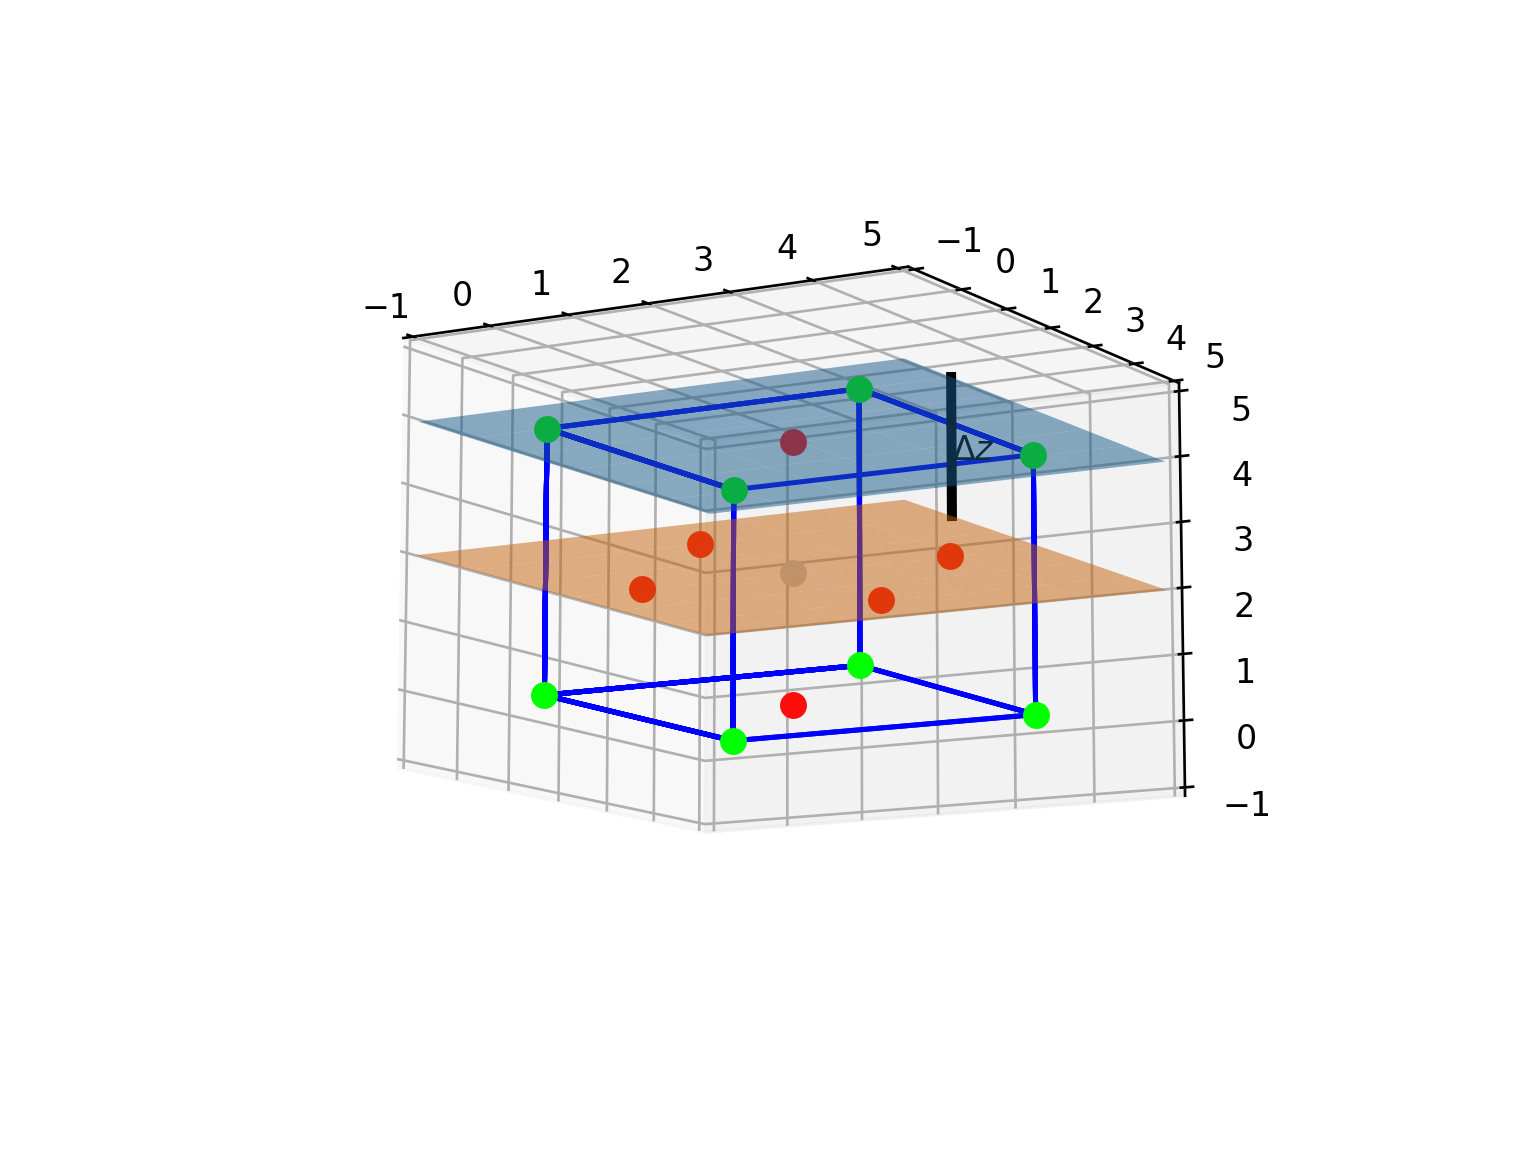

In [28]:
atoms = ks.structure_by_name('SrTiO3')
for i in range(len(atoms)):
    print(i, atoms[i].symbol, atoms.get_scaled_positions()[i])

super_cell = ks.ball_and_stick(atoms)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Corners and Outline of unit cell
h = (0, 1)
corner_vectors = np.dot(np.array(list(itertools.product(h, h, h))), atoms.cell)
trace = [[0, 1], [1, 3], [3, 2], [2, 0], [0, 4], [4, 5], [5, 7], [6, 7], [6, 4], [1, 5], [2, 6], [3, 7]]
corners = []
for s, e in trace:
    corners.append([*zip(corner_vectors[s], corner_vectors[e])])

    for x, y, z in corners:
        ax.plot3D(x, y, z, color='blue')

for i, atom in enumerate(super_cell.positions):
    ax.scatter(atom[0], atom[1], atom[2],
               color=tuple(ks.jmol_colors[super_cell.get_atomic_numbers()[i]]),
               alpha=1.0, s=50)
    
xx, yy = np.meshgrid(range(-1,6), range(-1,6))
z = xx*0+atoms.cell[2][2]
ax.plot_surface(xx, yy, z, alpha=0.5)
ax.plot_surface(xx, yy, z-atoms.cell[2][2]/2, alpha=0.5)
ax.text(5, 0., atoms.cell[2][2]*.7, "$\Delta z$", color='black')
ax.plot([5, 5], [0,0],zs=[atoms.cell[2][2]/2, atoms.cell[2][2]], color='black', linewidth=3)
ax.set_xlim(-1, 5)
ax.set_ylim(-1, 5)
ax.set_zlim(-1, 5);

Here we have two equidistant layers that we can read off the z-component of the base 
- one layer with z = 0.0 and 
- one layer with z = 0.5

Let's order atoms in a python dictionary *{ }* according to those layers

In [29]:
atoms = ks.structure_by_name('SrTiO3')
lattice_parameter = atoms.cell[0, 0]
pixel_size = lattice_parameter/(nx/n_cell_x)

positions = atoms.positions # in pixel
for i in range(len(atoms)):
    print(i, atoms[i].symbol, atoms.positions[i]/pixel_size)
layers = {}
layers[0] ={0:{'element': 'Sr', 'base': [atoms.positions[0, 0:2]]}, 
            1:{'element': 'O',  'base': [atoms.positions[3, 0:2]]}}
layers[1] ={0:{'element': 'Ti', 'base': [atoms.positions[1, 0:2]]}, 
            1:{'element': 'O',  'base': atoms.positions[[2,4], 0:2]}} 
print()
print(layers)

0 Sr [0. 0. 0.]
1 Ti [32. 32. 32.]
2 O [32. 32.  0.]
3 O [ 0. 32. 32.]
4 O [32.  0. 32.]

{0: {0: {'element': 'Sr', 'base': [array([0., 0.])]}, 1: {'element': 'O', 'base': [array([0.      , 1.952634])]}}, 1: {0: {'element': 'Ti', 'base': [array([1.952634, 1.952634])]}, 1: {'element': 'O', 'base': array([[1.952634, 1.952634],
       [1.952634, 0.      ]])}}}


Make slice

Sr
O
Ti
O


<IPython.core.display.Javascript object>


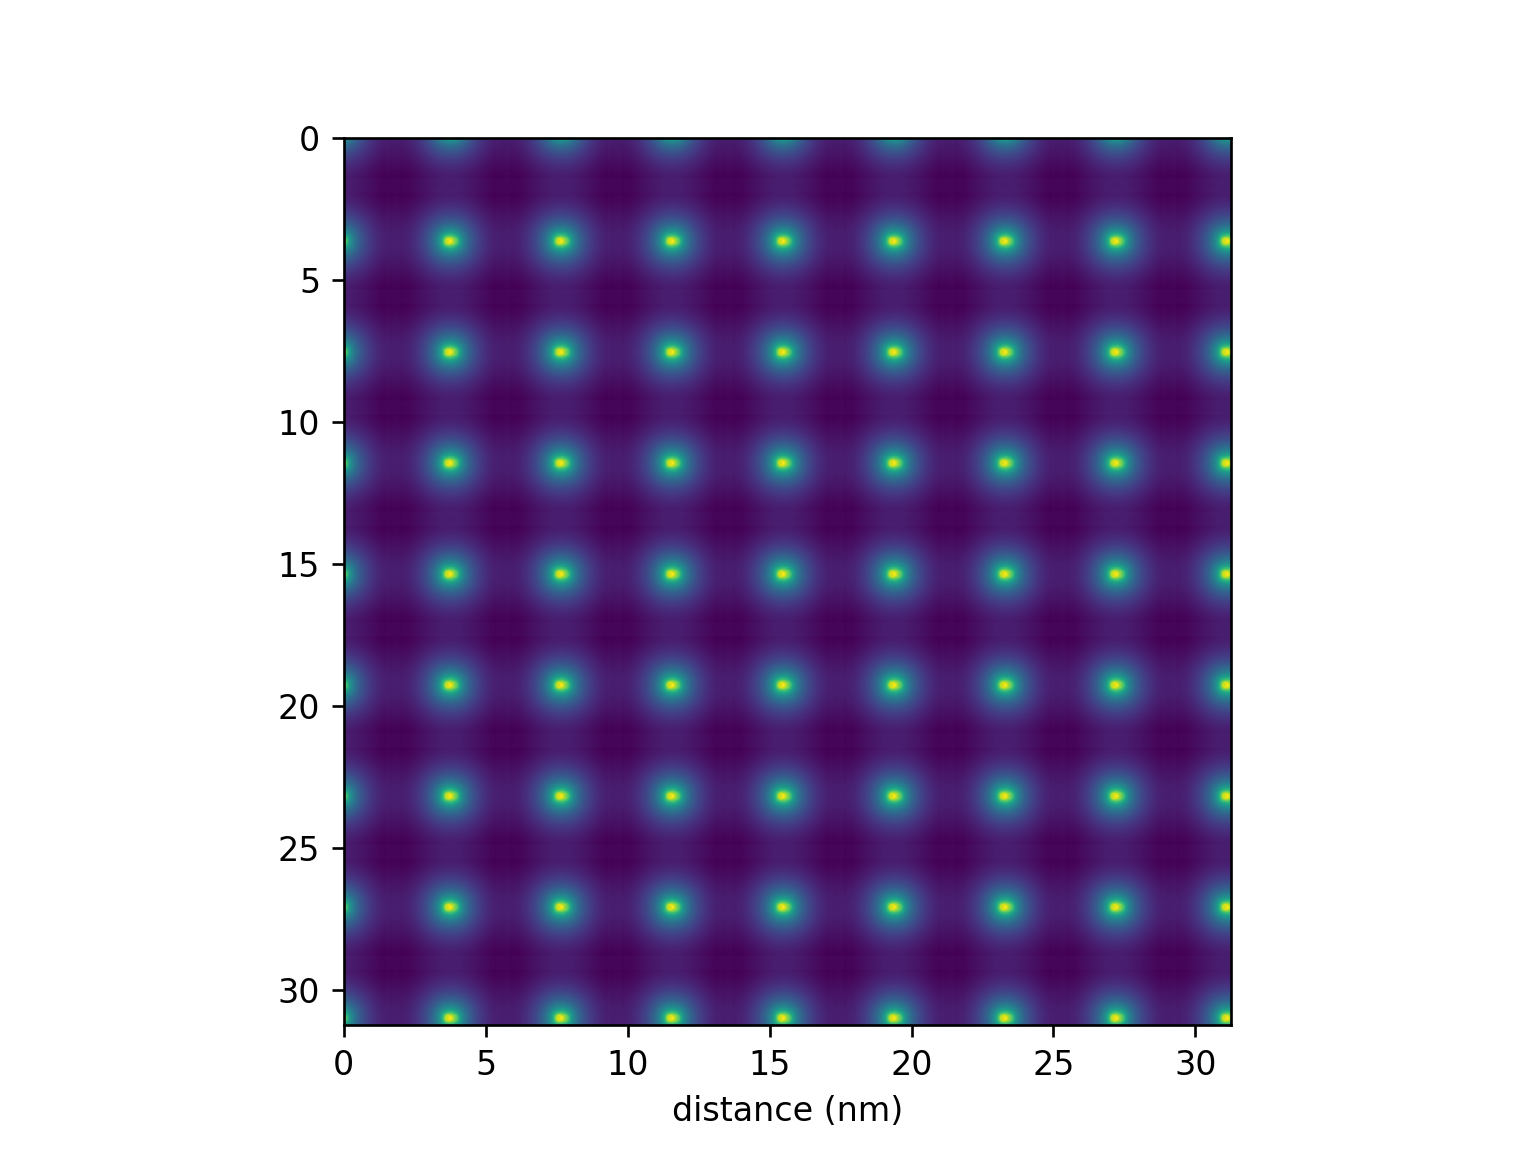

10500.605527100264


Text(0.5, 0, 'distance (nm)')

In [31]:
size_in_pixel = nx = ny = 512
n_cell_x = 8
a = atoms.cell[0,0]

potential = potential_2D('Si', nx, nx, n_cell_x, n_cell_x, a, [[0,0], [0.5,0.5]])
pixel_size = a/(nx/n_cell_x)

image_extent = [0, size_in_pixel*pixel_size, size_in_pixel*pixel_size,0]
slice_potentials = np.zeros([2,512,512])
for layer in layers:
    for atom in layers[layer]:
        elem = layers[layer][atom]['element']
        print(elem)
        pos = layers[layer][atom]['base']
        slice_potentials[layer] += potential_2D(elem, nx, nx, n_cell_x, n_cell_x, a, pos)
plt.figure()
#plt.imshow(layer_potentials.sum(axis=0))
print(slice_potentials.max())
plt.imshow(slice_potentials[1], extent = image_extent)
plt.xlabel('distance (nm)')

## Step 3: Transmission Function for Each Slice 

The slice acts like a **Very Thin Specimen** in the ``weak phase approximation``.
In that approximation, the sample causes only a phase change to the incident plane wave.

To retrieve the exit wave of that slice we just multiply the transmission function $t(\vec{x})$ with the plane wave $\exp (2\pi i k_z z)$

$$ \Psi_t(\vec{x}) = t(\vec{x}) \exp \left(2 \pi i k_z z \right) \approx t(\vec{x})  $$

The specimen transmission function depends on the projected potential $v_z(\vec{x})$ and the interaction parameter $\sigma$:
$$t(\vec{x}) =  \exp \left( i \sigma v_z(\vec{x})\right)$$

with the interaction parameter $\sigma$:
$$ 
\sigma = \frac{2 \pi}{\lambda V} \left(  \frac{m_0 c^2 + eV}{2m_0c^2+eV} \right) = \frac{2 \pi m  e_0 \lambda}{h^2}
$$
with $ m = \gamma m_0$ and $eV$ the incident electron energy.

<IPython.core.display.Javascript object>


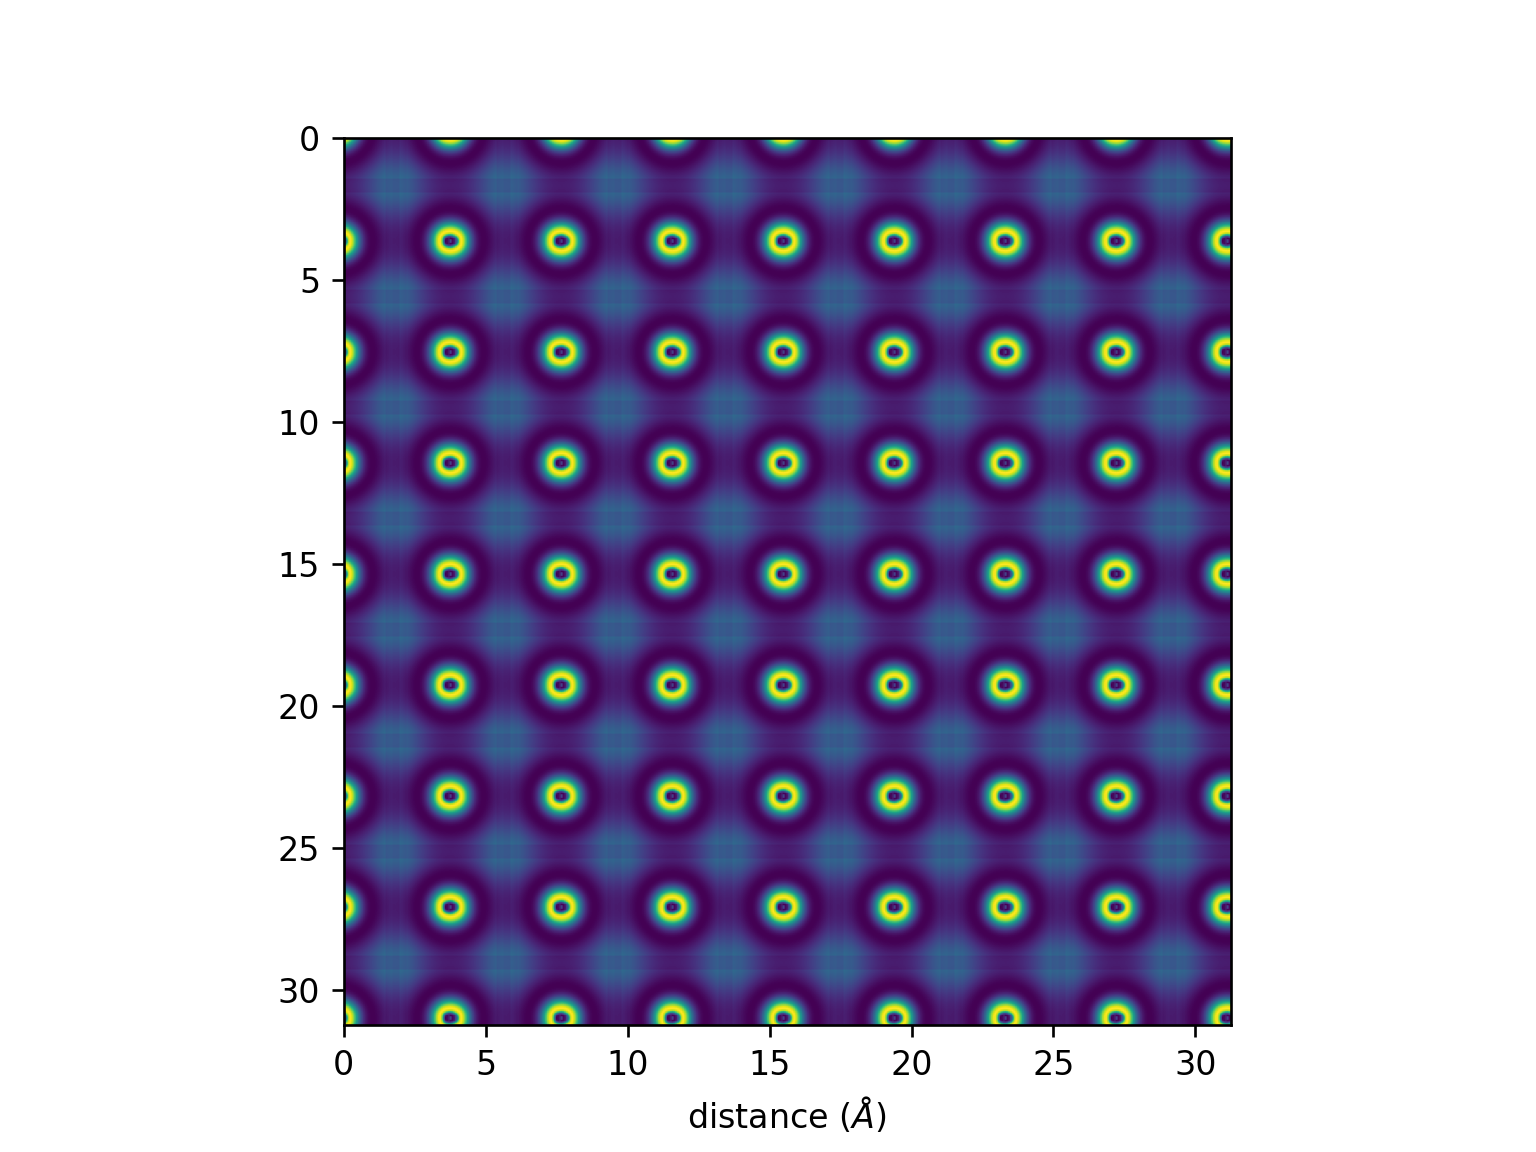

Text(0.5, 0, 'distance ($\\AA$)')

In [32]:
def interaction_parameter(acceleration_voltage):
    """Calculates interaction parameter sigma
    
    Parameter
    ---------
    acceleration_voltage: float
        acceleration voltage in volt
    
    Returns
    -------
    interaction parameter: float
        interaction parameter (dimensionless)
    """
    V = acceleration_voltage # in eV
    E0 = 510998.95 #  m_0 c^2 in eV
    
    wavelength = ks.get_wavelength(acceleration_voltage)
    E = acceleration_voltage
    
    return 2*np.pi/ (wavelength * E)  *(E0 + E)/(2*E0+E)


potential = np.array(slice_potentials, dtype=complex)

def get_transmission(sigma, potential):
    
    t = np.exp(1j*sigma* potential)
    return t
    
acceleration_voltage = 60000

sigma = interaction_parameter(acceleration_voltage)
transmission = get_transmission(sigma, potential)

plt.figure()
plt.imshow(transmission[1].imag, extent = image_extent)
plt.xlabel('distance ($\AA$)')



## Step 4: Propagator
The Fresnel propagator $p$ propagates the wave through the vacuum of the layers between the (flat) atom potentials.
$$
p(x,y, \Delta z) = \mathcal{F} P(k_x, k_y, \Delta z)
$$
Mathematically, this propagator function has to be  convoluted with the wave, which is a multiplication in Fourier space $\mathcal{F}$.

$$
P(k,\Delta z) = \exp(-i\pi \lambda k^2 \Delta z)
$$

The Fourier space is limited in reciprocal vector to avoid aliasing. We realize that with  an aperture function.

Here we assume a cubic crystal and equidistant layers, but that of course is not always true.

[1.952634, 1.952634]
5.462706614074458
Bandwidth limited to a real space resolution of 183.05943750000003 pm
   (= 89.80 mrad)  for symmetrical anti-aliasing.
Number of symmetrical non-aliasing beams = 91528


<IPython.core.display.Javascript object>


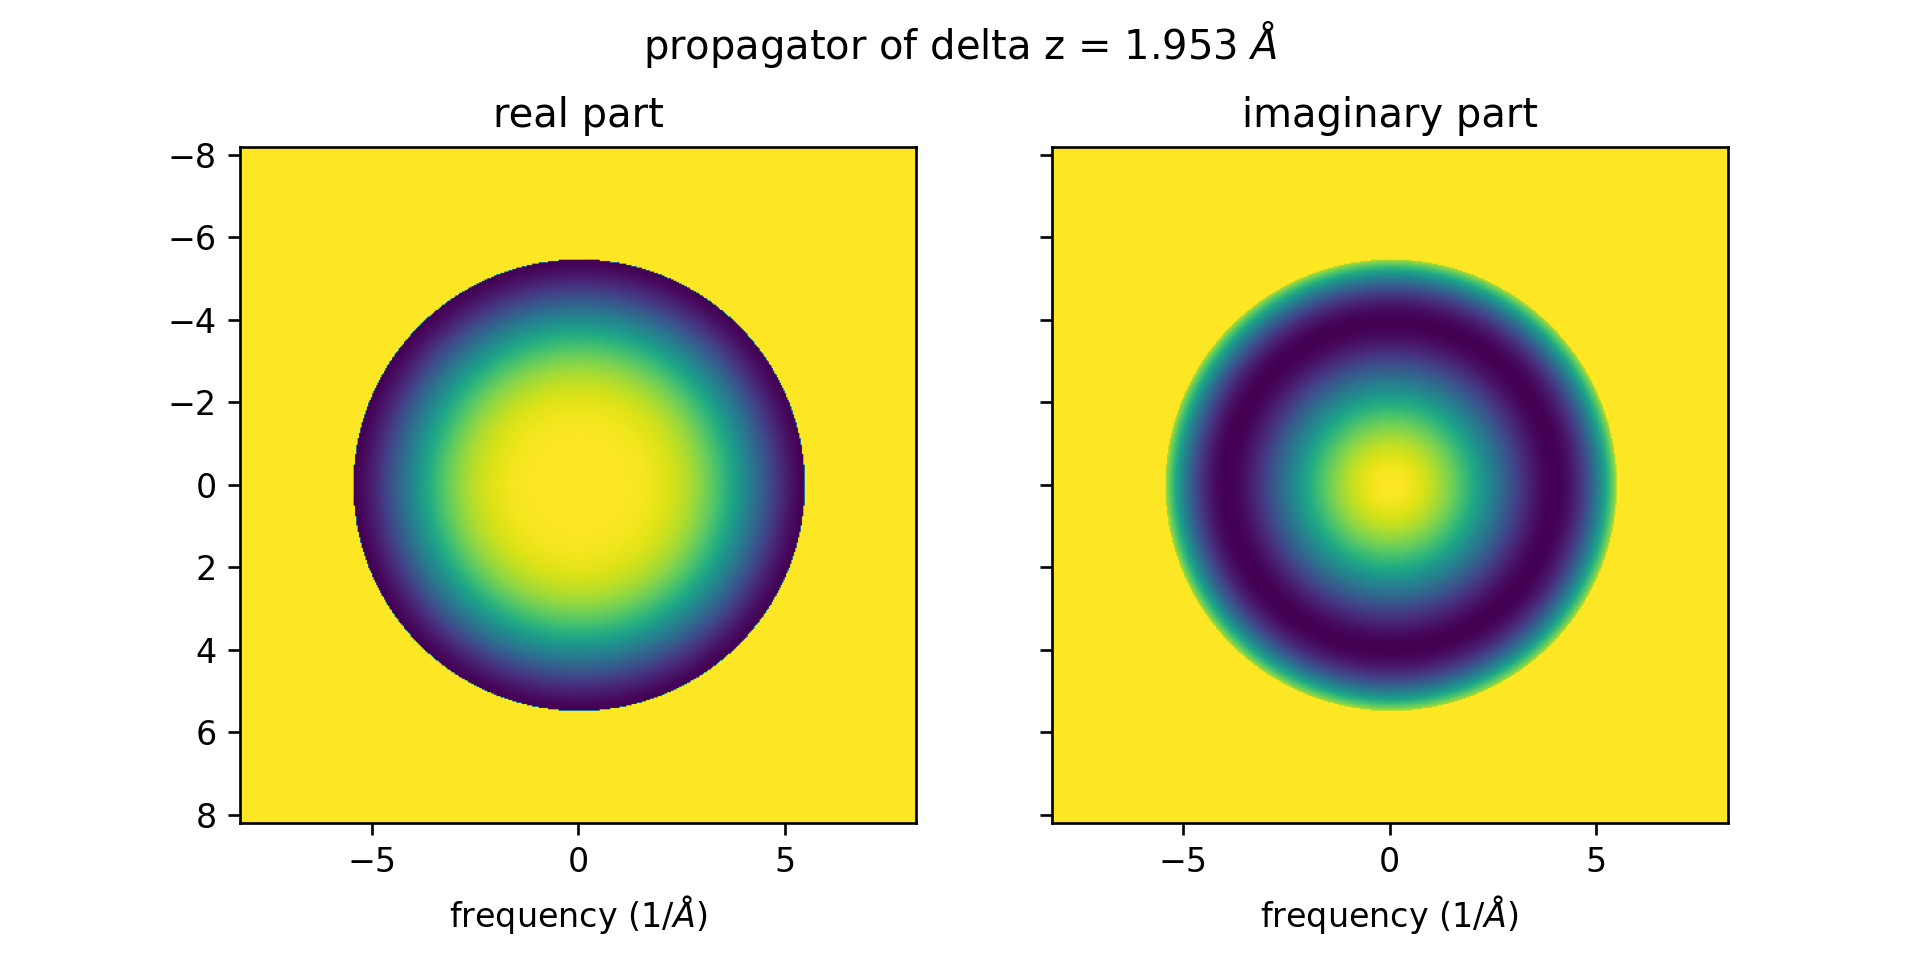

In [33]:
lattice_parameter = atoms.cell[0,0]
field_of_view = 8*lattice_parameter
size_in_pixel = 512
number_layers = 2
delta_z = [atoms.cell[2,2]/number_layers, atoms.cell[2,2]/number_layers]
print(delta_z)
wavelength = ks.get_wavelength(400000)
bandwidth_factor = 2/3   # Antialiasing bandwidth limit factor

def get_propagator(size_in_pixel, delta_z, number_layers, wavelength, field_of_view, bandwidth_factor, verbose=True):
    
    k2max = size_in_pixel/field_of_view/2. * bandwidth_factor 
    print(k2max)
    if verbose:
        print(f"Bandwidth limited to a real space resolution of {1.0/k2max*1000} pm")
        print(f"   (= {wavelength*k2max*1000.0:.2f} mrad)  for symmetrical anti-aliasing.")
    k2max = k2max*k2max;

    kx,ky = np.mgrid[-size_in_pixel/2:size_in_pixel/2, -size_in_pixel/2:size_in_pixel/2]/field_of_view
    k_square = kx**2+ky**2
    k_square[k_square>k2max]=0 # bandwidth limiting
    
    if verbose:
        temp = np.zeros([size_in_pixel,size_in_pixel]) 
        temp[k_square>0] = 1
        print(f"Number of symmetrical non-aliasing beams = {temp.sum():.0f}")
        
    propagator = np.zeros([number_layers, size_in_pixel, size_in_pixel], dtype=complex)
    for i in range(number_layers):
        propagator[i] = np.exp(-1j*np.pi*wavelength*k_square*delta_z[i])
    
    return propagator

propagator = get_propagator(size_in_pixel, delta_z, number_layers, wavelength, field_of_view, 
                             bandwidth_factor, verbose=True)

recip_FOV = size_in_pixel/field_of_view/2.
reciprocal_extent = [-recip_FOV,recip_FOV,recip_FOV,-recip_FOV]
layer = 0
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
fig.suptitle(f"propagator of delta z = {delta_z[layer]:.3f} $\AA$")
ax[0].set_title(f"real part")
ax[0].imshow(propagator[0].real,extent=reciprocal_extent)
ax[0].set_xlabel('frequency (1/$\AA$)')
ax[1].set_title(f"imaginary part")
ax[1].set_xlabel('frequency (1/$\AA$)')
ax[1].imshow(propagator[0].imag,extent=reciprocal_extent)


## Step 5: Incident Wave
That will be easy, in plane wave illumination all points have the same amplitude (here: 1) and phase (here: 0). We express that plane wave as a complex array.

A titled plane would be a little more complicated.

In [34]:
# Tilt not implemented yet
plane_wave = np.ones([nx,ny], dtype=complex)

## Step 6: Multislice Loop

Combining the transmission function $t$ and the Frensel propagator $p$ we get
for each slice:
$$
\Psi(x,y,z+\Delta z) = p(x,y,\Delta z) \otimes \left[t(x,y,z)\Psi(x,y,z) \right] + \mathcal{O}(\Delta z^2)
$$

or an expression that bettere relfects the iterative nature of this equation for starting layer n :

$$
\Psi_{n+1}(x,y,) = p_n(x,y,\Delta z) \otimes \left[t_n(x,y,z)\Psi_n(x,y,z) \right] + \mathcal{O}(\Delta z^2)
$$

Again the convolution $\otimes$ will be done as a multiplication in Fourier space.

simulated SrTiO3 for thickness 31.242 Angstrom


<IPython.core.display.Javascript object>


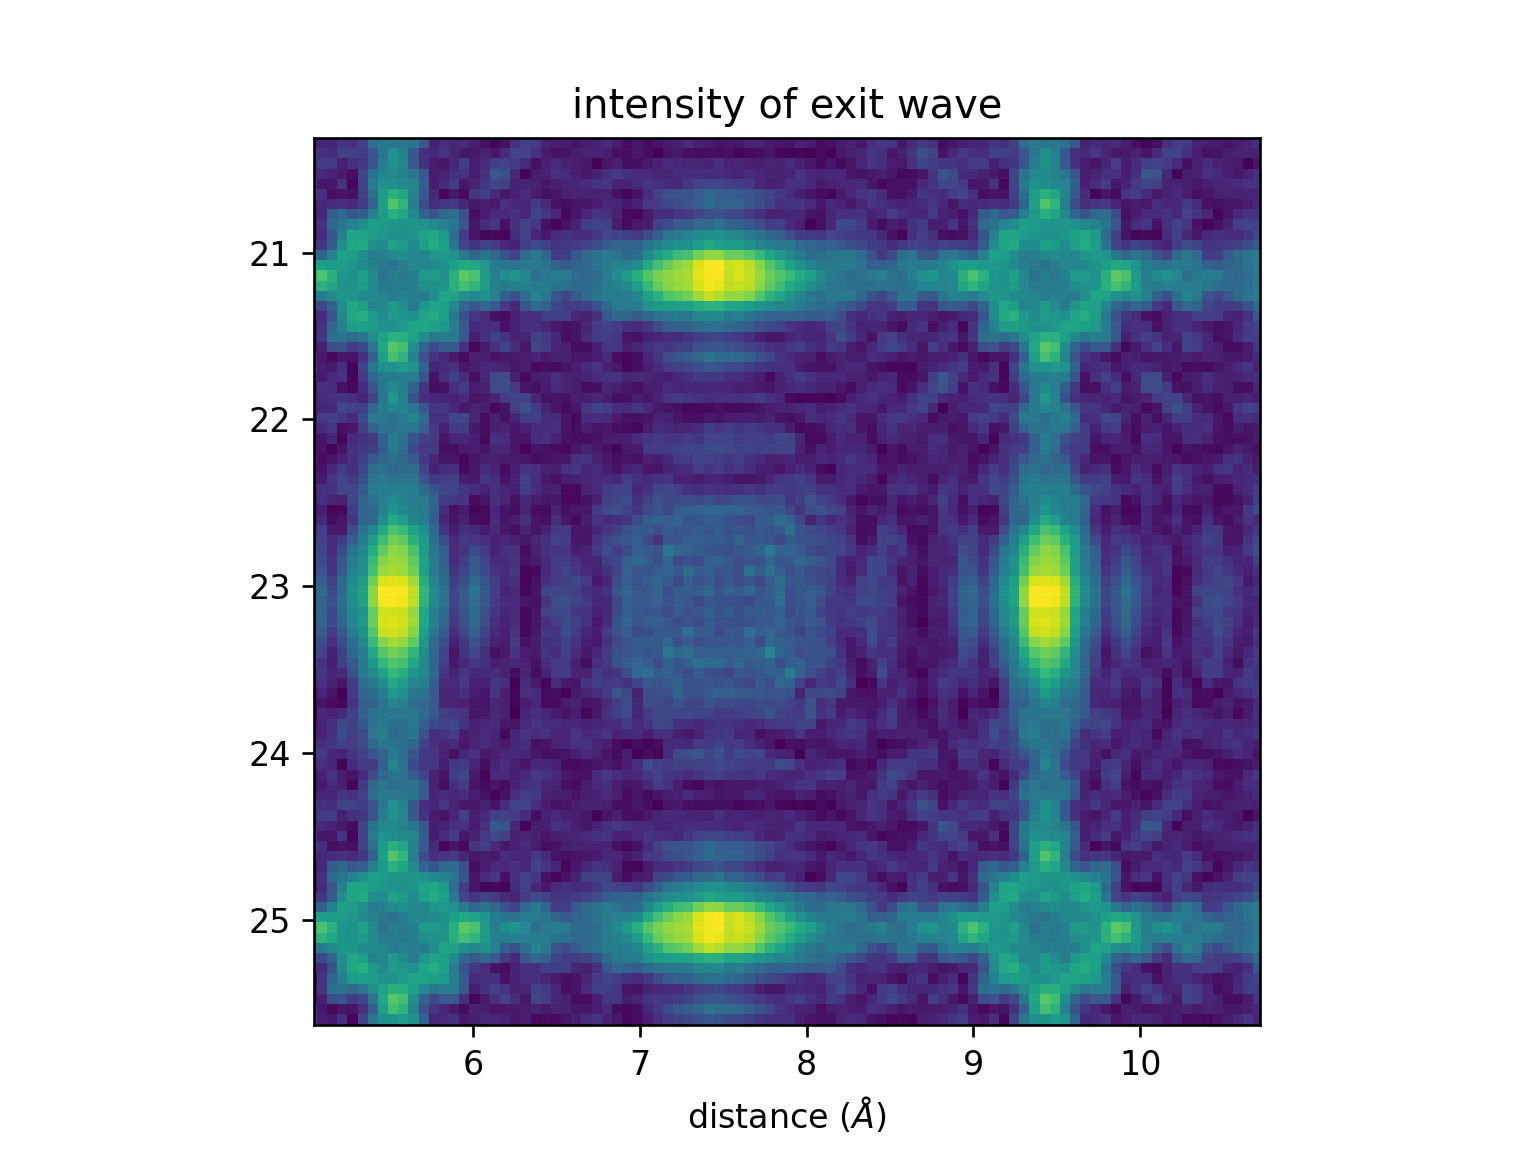

In [35]:
# ------Input------------- #
number_of_unit_cell_z = 8 # this will give us the thickness
# ------------------------ #    

def multi_slice(wave, number_of_unit_cell_z, acceleration_voltage, transmission, propagator):
    """Multislice Calculation
    
    One the array wave will be changed
    """
    sigma = interaction_parameter(acceleration_voltage)
    for i in range(number_of_unit_cell_z):
        for layer in range(number_layers): 
            wave = wave * transmission[layer] # transmission  - real space
            wave = np.fft.fft2(wave)
            wave = wave * propagator[layer]  # propagation; propagator is defined in reciprocal space
            wave = np.fft.ifft2(wave) #back to real space
    return wave

plane_wave = np.ones([size_in_pixel,size_in_pixel], dtype=complex)
exit_wave = multi_slice(plane_wave, number_of_unit_cell_z, acceleration_voltage, transmission, propagator)
    
print(f"simulated {atoms.info['title']} for thickness {number_of_unit_cell_z*atoms.cell[0,0]:.3f} Angstrom")

wave = np.fft.fft2(exit_wave)
intensity = np.abs(np.fft.fftshift(np.fft.ifft2(wave*wave)))

plt.figure()
plt.title('intensity of exit wave')
plt.imshow(intensity, extent = image_extent)
plt.xlabel('distance ($\AA$)');

## Diffraction Pattern

according to [J. M. Cowley and A. F. Moodie](https://doi.org/10.1107/S0365110X57002194), the diffraction pattern $U(u,v)$ is the Fourier transform of the exit wave function in the far-field (diffraction plane): 

$$
U(u,v) = \mathcal{F} \left( \exp(i*\varphi(x,y)) \right)
$$

where $\varphi$ is the exit wave of the crystal.

<IPython.core.display.Javascript object>


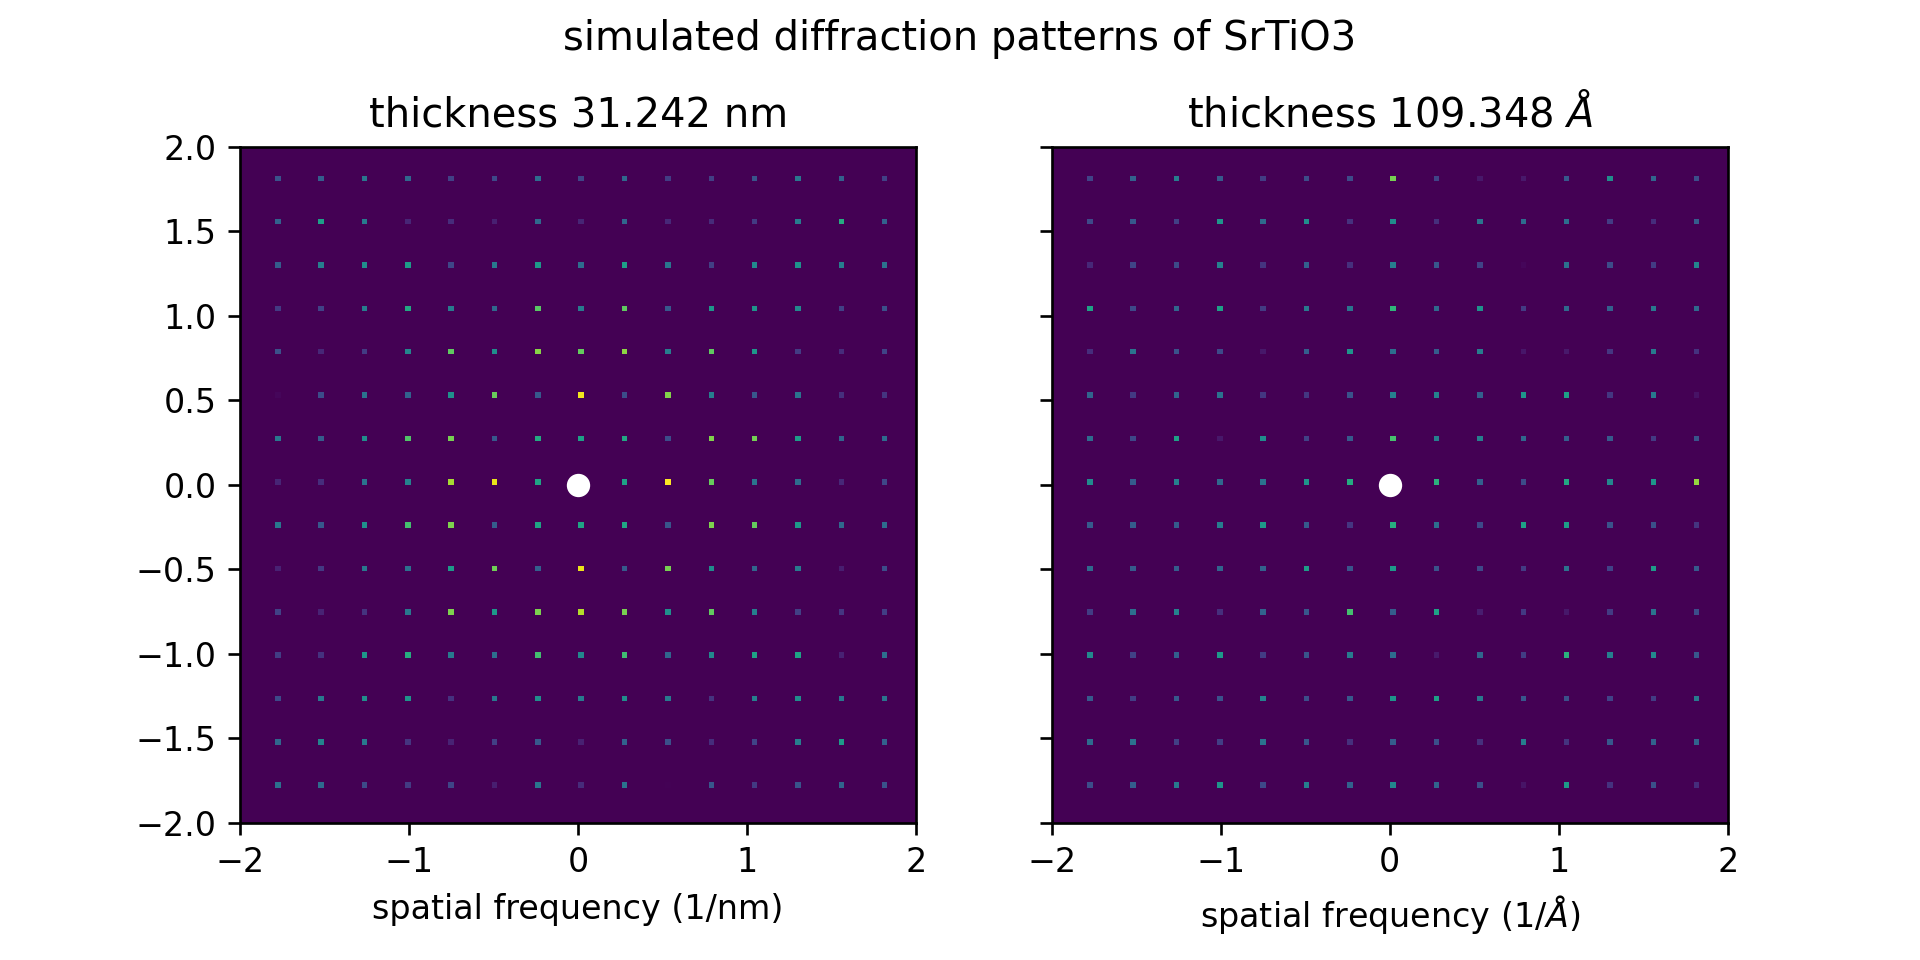

In [36]:
additional_layers = 20
diffraction_pattern = np.fft.fftshift(np.fft.fft2(np.exp(1j*exit_wave)))
diffraction_pattern[256,256] = 0

# adding a multislice calculation
exit_wave2 = multi_slice(exit_wave, additional_layers, acceleration_voltage, transmission, propagator)
diffraction_pattern2 = np.fft.fftshift(np.fft.fft2(np.exp(1j*exit_wave2)))
diffraction_pattern2[256,256] = 0

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
fig.suptitle(f"simulated diffraction patterns of {atoms.info['title']}")
ax[0].set_title(f"thickness {number_of_unit_cell_z*atoms.cell[0,0]:.3f} nm")
ax[0].imshow(np.abs(diffraction_pattern), extent=reciprocal_extent)
ax[0].set_xlabel('spatial frequency (1/nm)')
ax[1].set_title(f"thickness {(number_of_unit_cell_z+additional_layers)*atoms.cell[0,0]:.3f} $\AA$")
ax[1].imshow(np.abs(diffraction_pattern2), extent=reciprocal_extent)
ax[1].set_xlabel('spatial frequency (1/$\AA$)')
ax[0].scatter(0,0, color='white')
ax[1].scatter(0,0, color='white')

ax[1].set_aspect('equal')
ax[1].set_xlim(-2,2)
ax[1].set_ylim(-2,2);

## Summary

The multislice algrithm allows to calculate all the dynamic diffraction effects we need. 

More sophisticated program allowmore flexibility and include frozen phonon calculatins and differ

